In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [5]:
FIN_PATH = "/home/pedda/Documents/uni/FIN-Dataset"
scenes = os.listdir(FIN_PATH)
algorithms = ["draco","pccomp","tmc3"]
scenes
algorithms

['draco', 'pccomp', 'tmc3']

In [6]:
def gather_dfs(scene: str):
    root = os.path.join(FIN_PATH, scene)
    qual_data = dict()
    sim_data = dict()
    for subdir in os.listdir(root):
        if not os.path.isdir(os.path.join(root, subdir)) or subdir == "GT":
            continue
        metrics_path = os.path.join(root, subdir, "metrics", f"{subdir}-{scene}.csv")
        sim_path = os.path.join(root, subdir, "metrics", f"{subdir}-{scene}-sim.csv")
        metrics = pd.read_csv(metrics_path)
        sim = pd.read_csv(sim_path)
        sim["Cloud Size"] = metrics["num_points"]
        metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
        qual_data[subdir] = metrics
        sim_data[subdir] = sim
    return qual_data, sim_data

In [7]:
def gather_dfs_local(scene):
    root = "metrics"
    qual_data = dict()
    sim_data = dict()
    for algorithm in algorithms:
        metrics_path = os.path.join(root, f"{algorithm}-{scene}-qual.csv")
        sim_path = os.path.join(root, f"{algorithm}-{scene}-sim.csv")
        metrics = pd.read_csv(metrics_path)
        sim = pd.read_csv(sim_path)
        sim["Cloud Size"] = metrics["num_points"]
        metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
        qual_data[algorithm] = metrics
        sim_data[algorithm] = sim
    return qual_data, sim_data

In [16]:
qual_data, sim_data = gather_dfs_local()
sim_data

{'hallway':          Filename  Symmetric Similarity  Cloud Size
 0      hallway-T0              0.903851         108
 1      hallway-T1              0.903074         330
 2     hallway-T10              0.881391         663
 3    hallway-T100              0.887273        6474
 4    hallway-T101              0.887091       14646
 ..            ...                   ...         ...
 164   hallway-T95              0.887632      892788
 165   hallway-T96              0.887525      896679
 166   hallway-T97              0.887433      904530
 167   hallway-T98              0.887575      908724
 168   hallway-T99              0.887672      911340
 
 [169 rows x 3 columns],
 'auditorium':             Filename  Symmetric Similarity  Cloud Size
 0      auditorium-T0              0.915973        2550
 1      auditorium-T1              0.911859       13563
 2     auditorium-T10              0.874558       24081
 3    auditorium-T100              0.881907       37614
 4    auditorium-T101           

In [8]:
def gather_all():
    qual_data = dict()
    sims_data = dict()
    for scene in scenes:
        qual_data[scene], sims_data[scene] = gather_dfs_local(scene)
    return qual_data, sims_data
        

scene_qual_data, scene_sim_data = gather_all()
scene_sim_data


{'hallway': {'draco':          Filename  Symmetric Similarity  Cloud Size
  0      hallway-T0              0.999055         108
  1      hallway-T1              0.997570         330
  2      hallway-T2              0.995373         663
  3      hallway-T3              0.985614        6474
  4      hallway-T4              0.972539       14646
  ..            ...                   ...         ...
  164  hallway-T164              0.843523      892788
  165  hallway-T165              0.843524      896679
  166  hallway-T166              0.843821      904530
  167  hallway-T167              0.843941      908724
  168  hallway-T168              0.843955      911340
  
  [169 rows x 3 columns],
  'pccomp':          Filename  Symmetric Similarity  Cloud Size
  0      hallway-T0              0.901232         108
  1      hallway-T1              0.973187         330
  2     hallway-T10              0.998859         663
  3    hallway-T100              0.995168        6474
  4    hallway-T101    

In [10]:
algo_all = dict()
for scene in os.listdir(FIN_PATH):
    for algo, df in scene_qual_data[scene].items():
        if not algo in algo_all:
            algo_all[algo] = df
        else:
            algo_all[algo] = pd.concat([algo_all[algo],df])

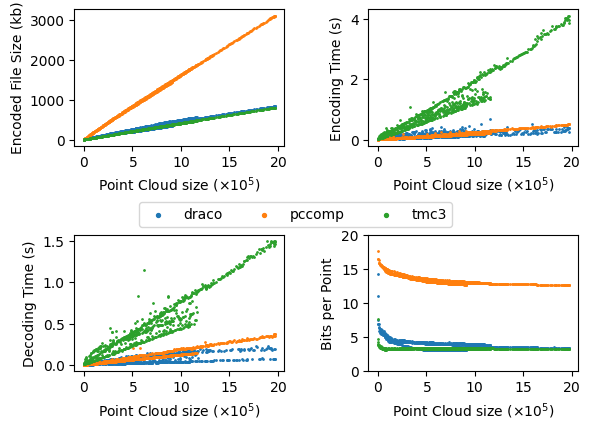

In [92]:
fig, axs = plt.subplots(2,2)
ls = []
import matplotlib.ticker as mtick
algorithms = []
for algorithm, df in algo_all.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"] / 10**5
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_ylabel("Encoded File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_ylabel("Encoding Time (s)")
    axs[1, 0].scatter(points, time_dec, s=1)
    axs[1, 0].set_ylabel("Decoding Time (s)")
    axs[1, 1].scatter(points, bpps, s=1, label=algorithm)
    axs[1, 1].set_ylabel("Bits per Point")
    axs[1, 1].set_ylim(0, 20)
for ax in axs.flat:
    ax.set_xlabel("Point Cloud size ($\\times 10^5$)")
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
lgnd = fig.legend(ls, algorithms, loc="center", ncols=(3))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)
plt.show()

/tmp/ipykernel_8915/3923985010.py:25: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.5)


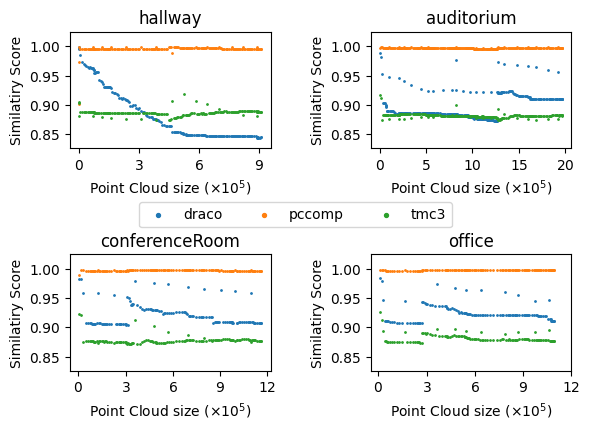

In [91]:
fig, axs = plt.subplots(2, 2, constrained_layout = True)
ls = []
for i, scene in enumerate(scenes):
    for algo, df in scene_sim_data[scene].items():
        similarity = df["Symmetric Similarity"]    
        cloud_size = df["Cloud Size"] / 10**5
        l = axs.flat[i].scatter(cloud_size, similarity, s=1)
        ls.append(l)
        if scene == "hallway":
            axs.flat[i].set_xticks([0, 3, 6,  9])
        if scene == "auditorium":
            axs.flat[i].set_xticks([0, 5, 10, 15, 20])
        if scene == "office":
            axs.flat[i].set_xticks([0, 3, 6,  9, 12])
        if scene == "conferenceRoom":
            axs.flat[i].set_xticks([0, 3, 6, 9, 12])
        axs.flat[i].set_ylim([0.825, 1.025])
        axs.flat[i].set_xlabel("Point Cloud size ($\\times 10^5$)")
        axs.flat[i].xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        axs.flat[i].set_title(scene)
        axs.flat[i].set_ylabel("Similatiry Score")
lgnd = fig.legend(ls, algorithms, loc="center", ncols=(3))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)

plt.show()

In [11]:
algo_all

{'draco':                  file        bpp  enc_file_size_bits  time_dec_ns  num_points  \
 0          T0-108.ply  32.148148                3472      3203166         108   
 1          T1-330.ply  14.206061                4688      6778865         330   
 2          T2-663.ply  11.028658                7312      6827248         663   
 3         T3-6474.ply   6.921223               44808      8584859        6474   
 4        T4-14646.ply   5.857162               85784     10131603       14646   
 ..                ...        ...                 ...          ...         ...   
 114  T114-1082778.ply   3.939253             4265336     41504241     1082778   
 115  T115-1085112.ply   3.937710             4272856     84940178     1085112   
 116  T116-1087941.ply   3.936074             4282216     41912606     1087941   
 117  T117-1091295.ply   3.934328             4293512     75429698     1091295   
 118  T118-1092495.ply   3.933638             4297480    151065247     1092495   
 
     

In [30]:
for algo, df in algo_all.items():
    similarity = df["Symmetric Similarity"]    
    bpp = df["bpp"]    
    avg_sim = np.average(similarity)
    avg_bpp = np.average(bpp)
    avg_enc = np.average(np.divide(df["time_enc_ns"], df["num_points"]))
    avg_dec = np.average(np.divide(df["time_dec_ns"], df["num_points"]))
    print(algo)
    print(f"\tAvg. similarity score: {avg_sim}")
    print(f"\tAvg. bpp:              {avg_bpp}")
    print(f"\tAvg. enc:              {avg_enc} ns")
    print(f"\tAvg. dec:              {avg_dec} ns")

draco
	Avg. similarity score: 0.9031001993918608
	Avg. bpp:              4.025135195827744
	Avg. enc:              396.61299169488115 ns
	Avg. dec:              220.2084702720343 ns
pccomp
	Avg. similarity score: 0.9968869760060668
	Avg. bpp:              13.540636542380938
	Avg. enc:              281.9883370400417 ns
	Avg. dec:              173.95113008909925 ns
tmc3
	Avg. similarity score: 0.8817870171960147
	Avg. bpp:              3.3146419977097863
	Avg. enc:              1925.2952392860846 ns
	Avg. dec:              938.4282876881683 ns
